Assignment 2: Reinforcement Learning - 2024-01 INF-2600 AI Methods & Applications
=====================================

**Author**: [Antonio Luque](https://github.com/antonioluque)
**, editing original work from**: [Adam Paszke](https://github.com/apaszke)

:   [Mark Towers](https://github.com/pseudo-rnd-thoughts)

This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN)
agent on the CartPole-v1 task from
[Gymnasium](https://gymnasium.farama.org).

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find more
information about the environment and other more challenging
environments at [Gymnasium\'s
website](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

![CartPole](https://pytorch.org/tutorials/_static/img/cartpole.gif)

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more than
2.4 units away from center. This means better performing scenarios will
run for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.). We
take these 4 inputs without any scaling and pass them through a small
fully-connected network with 2 outputs, one for each action. The network
is trained to predict the expected value for each action, given the
input state. The action with the highest expected value is then chosen.

**Packages**

First, let\'s import needed packages. Firstly, we need
[gymnasium](https://gymnasium.farama.org/) for the environment,
installed by using [pip]{.title-ref}. This is a fork of the original
OpenAI Gym project and maintained by the same team since Gym v0.19. If
you are running this in Google Colab, run:

``` {.sourceCode .bash}
%%bash
pip3 install gymnasium[classic_control]
```

We\'ll also use the following from PyTorch:

-   neural networks (`torch.nn`)
-   optimization (`torch.optim`)
-   automatic differentiation (`torch.autograd`)


In [ ]:
%%bash
pip3 install gymnasium[classic_control]

In [51]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Replay Memory
=============

We\'ll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we\'re going to need two classes:

-   `Transition` - a named tuple representing a single transition in our
    environment. It essentially maps (state, action) pairs to their
    (next\_state, reward) result, with the state being the screen
    difference image as described later on.
-   `ReplayMemory` - a cyclic buffer of bounded size that holds the
    transitions observed recently. It also implements a `.sample()`
    method for selecting a random batch of transitions for training.


In [52]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let\'s define our model. But first, let\'s quickly recap what a DQN
is.

DQN algorithm
=============

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where $R_{t_0}$
is also known as the *return*. The discount, $\gamma$, should be a
constant between $0$ and $1$ that ensures the sum converges. A lower
$\gamma$ makes rewards from the uncertain far future less important for
our agent than the ones in the near future that it can be fairly
confident about. It also encourages agents to collect reward closer in
time than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell us
what our return would be, if we were to take an action in a given state,
then we could easily construct a policy that maximizes our rewards:

$$\pi^*(s) = \arg\!\max_a \ Q^*(s, a)$$

However, we don\'t know everything about the world, so we don\'t have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble $Q^*$.

For our training update rule, we\'ll use a fact that every $Q$ function
for some policy obeys the Bellman equation:

$$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

$$\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))$$

To minimize this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate this
over a batch of transitions, $B$, sampled from the replay memory:

$$\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)$$

$$\begin{aligned}
\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
  \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
  |\delta| - \frac{1}{2} & \text{otherwise.}
\end{cases}
\end{aligned}$$

Q-network
---------

Our model will be a feed forward neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$
(where $s$ is the input to the network). In effect, the network is
trying to predict the *expected return* of taking each action given the
current input.


In [53]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Training
========

Hyperparameters and utilities
-----------------------------

This cell instantiates our model and its optimizer, and defines some
utilities:

-   `select_action` - will select an action accordingly to an epsilon
    greedy policy. Simply put, we\'ll sometimes use our model for
    choosing the action, and sometimes we\'ll just sample one uniformly.
    The probability of choosing a random action will start at
    `EPS_START` and will decay exponentially towards `EPS_END`.
    `EPS_DECAY` controls the rate of the decay.
-   `plot_durations` - a helper for plotting the duration of episodes,
    along with an average over the last 100 episodes (the measure used
    in the official evaluations). The plot will be underneath the cell
    containing the main training loop, and will update after every
    episode.


In [54]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Training loop
=============

Finally, the code for training our model.

Here, you can find an `optimize_model` function that performs a single
step of the optimization. It first samples a batch, concatenates all the
tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our loss. By
definition we set $V(s) = 0$ if $s$ is a terminal state. We also use a
target network to compute $V(s_{t+1})$ for added stability. The target
network is updated at every step with a [soft
update](https://arxiv.org/pdf/1509.02971.pdf) controlled by the
hyperparameter `TAU`, which was previously defined.


In [55]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial `state` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always 1),
and optimize our model once. When the episode ends (our model fails), we
restart the loop.

Below, [num\_episodes]{.title-ref} is set to 600 if a GPU is available,
otherwise 50 episodes are scheduled so training does not take too long.
However, 50 episodes is insufficient for to observe good performance on
CartPole. You should see the model constantly achieve 500 steps within
600 training episodes. Training RL agents can be a noisy process, so
restarting training can produce better results if convergence is not
observed.


Complete


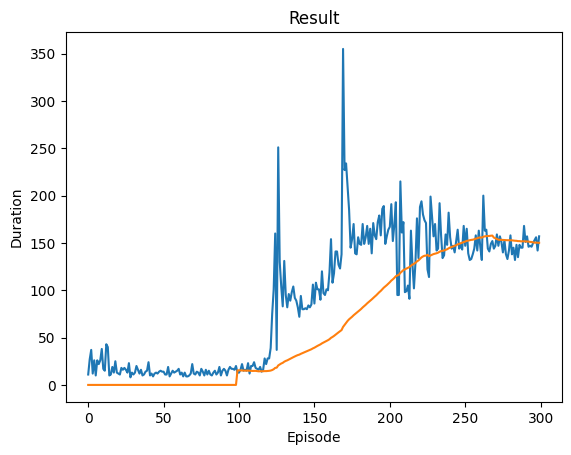

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [56]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here is the diagram that illustrates the overall resulting data flow.

![](https://pytorch.org/tutorials/_static/img/reinforcement_learning_diagram.jpg)

Actions are chosen either randomly or based on a policy, getting the
next step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training
of the new policy. The \"older\" target\_net is also used in
optimization to compute the expected Q values. A soft update of its
weights are performed at every step.


## ***Observe the effects of changing the exploration vs exploitation. (Show results in plots or print statements):***

Here, We try a more conservative approach to exploration, changing the EPS_START to 0.5
And We try a slower decay, allowing more exploration time.


Complete


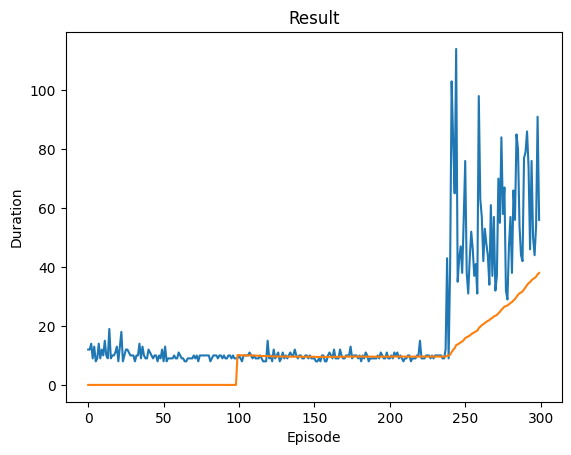

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [57]:
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 200
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here, We try a fast Decay that allow us to quickly move from exploring to exploiting the learned values. (EPS_START = 0.9).
Faster Decay, less time spent exploring (EPS_DECAY):


Complete


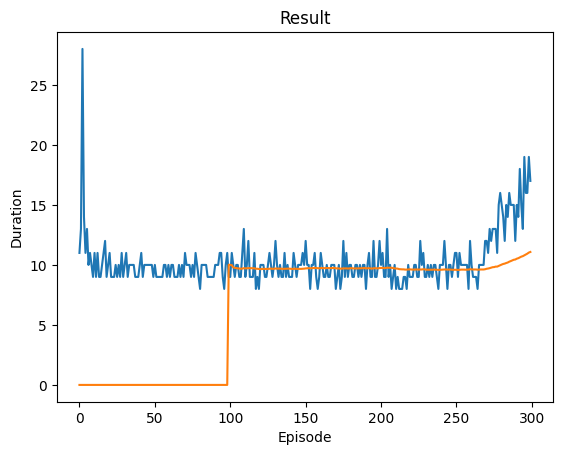

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [58]:
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


Lastly, Slow Decay of Exploration: Longer time exploring before settling into exploitation.
Slower decay, more time spent exploring(EPS_DECAY):


Complete


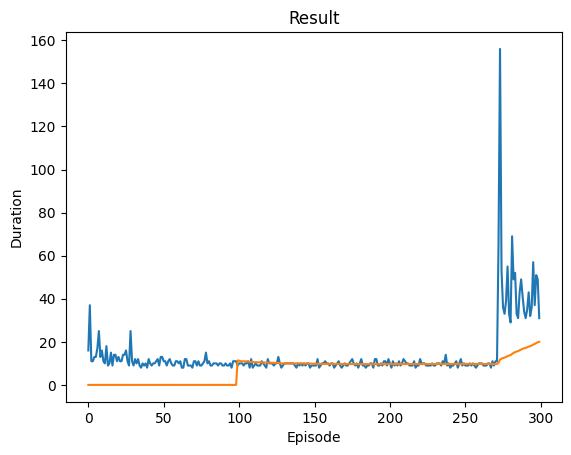

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [59]:
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 300

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


## ***Vary the number of layers in the model and plot episode vs duration plots. Maybe good to keep an eye on how long!***

In [60]:
import time

Episode 299 completed in 0.41858434677124023 seconds.
Complete
Total training time: 256.3406136035919 seconds


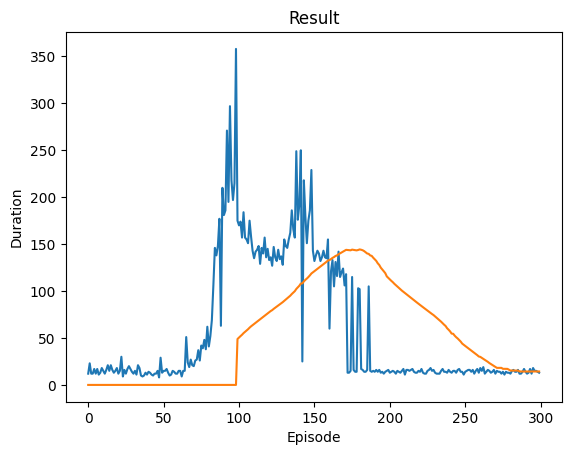

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [61]:
class DQN_4Layer(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_4Layer, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

### ~~~~~~ TRAINING ~~~~~~ ###
total_start_time = time.time()  # Starting the timer for total training time
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN_4Layer(n_observations, n_actions).to(device)
target_net = DQN_4Layer(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


### ~~~~~~ TRAINING LOOP ~~~~~~ ###
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### ~~~~~~ PLOTTING ~~~~~~ ###

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    episode_start_time = time.time()  # Start the timer for the current episode
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            episode_end_time = time.time()  # Ending the timer for the current episode
            print(f"Episode {i_episode} completed in {episode_end_time - episode_start_time} seconds.")
            break

print('Complete')
total_end_time = time.time()  # End the timer for total training time
print(f"Total training time: {total_end_time - total_start_time} seconds")
plot_durations(show_result=True)
plt.ioff()
plt.show()

Episode 299 completed in 0.8104770183563232 seconds.
Complete
Total training time: 491.55265188217163 seconds


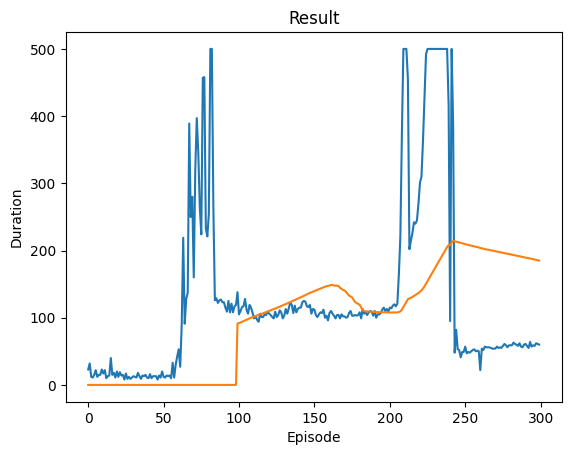

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [62]:
class DQN_5Layer(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_5Layer, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 128)
        self.layer5 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)

### ~~~~~~ TRAINING ~~~~~~ ###
total_start_time = time.time()  # Starting the timer for total training time
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN_5Layer(n_observations, n_actions).to(device)
target_net = DQN_5Layer(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


### ~~~~~~ TRAINING LOOP ~~~~~~ ###
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### ~~~~~~ PLOTTING ~~~~~~ ###

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    episode_start_time = time.time()  # Starting the timer for the current episode
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            episode_end_time = time.time()  # Ending the timer for the current episode
            print(f"Episode {i_episode} completed in {episode_end_time - episode_start_time} seconds.")
            break

print('Complete')
total_end_time = time.time()  # Ending the timer for total training time
print(f"Total training time: {total_end_time - total_start_time} seconds")
plot_durations(show_result=True)
plt.ioff()
plt.show()


Upon reviewing the outcomes of the three different setups, it appears that the extra layers in the neural networks don't necessarily translate into better results. The first setup with three layers held its own against the others with more layers. Each setup had its ups and downs across the trials, but overall, the additional complexity didn't give us any clear advantage. Plus, the more layers we added, the longer it took to run through the training, even if it was only by a small margin. So, sticking to a simpler approach might be the way to go here, especially since it gets the job done without extra bells and whistles.

#### Implement without the replay buffer and observe performance.

Episode 299 completed in 0.32130908966064453 seconds.
Complete
Total training time: 110.4404947757721 seconds


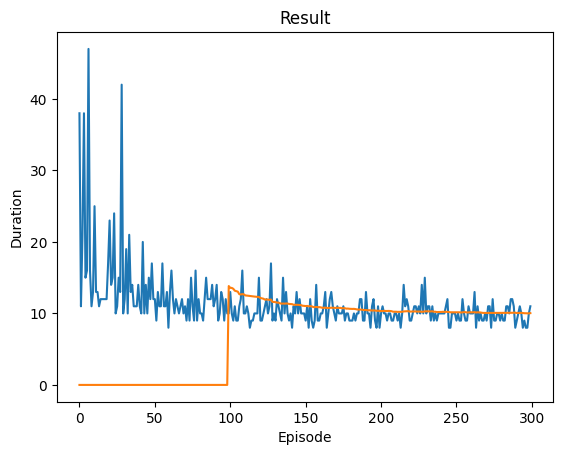

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [63]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### ~~~~~~ TRAINING ~~~~~~ ###
total_start_time = time.time()  # Starting the timer for total training time
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
# memory = ReplayMemory(10000)   -> We remove it in order to not use the replay buffer

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


### ~~~~~~ TRAINING LOOP ~~~~~~ ###

# def optimize_model():
#     if len(memory) < BATCH_SIZE:
#         return
#     transitions = memory.sample(BATCH_SIZE)
#     batch = Transition(*zip(*transitions))
#     non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                           batch.next_state)), device=device, dtype=torch.bool)
#     non_final_next_states = torch.cat([s for s in batch.next_state
#                                                 if s is not None])
#     state_batch = torch.cat(batch.state)
#     action_batch = torch.cat(batch.action)
#     reward_batch = torch.cat(batch.reward)

#     state_action_values = policy_net(state_batch).gather(1, action_batch)

#     next_state_values = torch.zeros(BATCH_SIZE, device=device)
#     with torch.no_grad():
#         next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
#     # Compute the expected Q values
#     expected_state_action_values = (next_state_values * GAMMA) + reward_batch

#     # Compute Huber loss
#     criterion = nn.SmoothL1Loss()
#     loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

#     # Optimize the model
#     optimizer.zero_grad()
#     loss.backward()
#     # In-place gradient clipping
#     torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
#     optimizer.step()

# For implementing it without the replay buffer we will need the following function
# This function teach the agent to predict the value of its action better by continuosly
# learning from the new things it experiences
def optimize_model_single_experience(state, action, next_state, reward):
    # Computing Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken

    # print(f"state shape: {state.shape}")
    # print(f"action shape: {action.shape}")
    # print(f"Q_current shape: {policy_net(state).shape}")

    Q_current = policy_net(state).gather(1, action)
    # the network (policy_net) predicts the Q-values for all possible actions
    # The .gather method is then used to select the Q-values for the action that was actually taken

    # Compute the expected Q values
    Q_next = torch.zeros_like(Q_current) # If it's the end of the episode, the Q-value is assumed to be zero, since there are no future rewards expected
    if next_state is not None: #  If the next state (next_state) is not the end of the episode (i.e., not None)
        Q_next = target_net(next_state).max(1)[0].detach()
        # The target network (target_net) predicts the Q-values for the next state
        # The .max(1)[0] operation selects the maximum Q-value across all possible next actions
    expected_Q = (Q_next * GAMMA) + reward

    # Compute loss
    loss = F.smooth_l1_loss(Q_current, expected_Q.unsqueeze(1))
    # The loss function (F.smooth_l1_loss) computes how much the prediction deviates from the target

    # Optimize the model
    optimizer.zero_grad() # .zero_grad() is called to clear any existing gradients
    loss.backward() # The loss is backpropagated through the network by calling .backward() on it
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1) # he clamp_ operation is used to prevent the gradients from getting too large, which can help stabilize training
    optimizer.step() # After backpropagation, .step() is called on the optimizer to actually perform the weight update


### ~~~~~~ PLOTTING ~~~~~~ ###

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    episode_start_time = time.time()  # Start the timer for the current episode
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Perform one step of the optimization (on the policy network) using the single experience
        optimize_model_single_experience(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            episode_end_time = time.time()  # Ending the timer for the current episode
            print(f"Episode {i_episode} completed in {episode_end_time - episode_start_time} seconds.")
            break

print('Complete')
total_end_time = time.time()  # End the timer for total training time
print(f"Total training time: {total_end_time - total_start_time} seconds")
plot_durations(show_result=True)
plt.ioff()
plt.show()

Adding more layers to the network when not using a replay buffer does not necessarily lead to better or more stable learning here and also It is shown that a replay buffer might play a crucial role in stabilizing the training process by providing a more diverse set of experiences during the learning updates.

# **Task 2 - CartPole2DEnv**
## ***•Use the precode provided in the file “Assignement_2_task_2.py” and repeat the sub-tasks listed for Task 1. Adjust the number of episodes to match your compute needs***

## ***•Note, there is no render function provided in the pre-code. See the figure below to get an idea.***

In [ ]:
%%bash
pip install ipdb

In [64]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import ipdb
import pygame
import math
import time
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import math
from typing import Optional, Union

import gym
from gym import logger, spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CartPole2DEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(self, render_mode: Optional[str] = None):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4      # Use for y_threshold as well

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                self.x_threshold * 2,
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state = None

        self.steps_beyond_terminated = None

    def step(self, action):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, y, y_dot, theta_x, theta_x_dot,  theta_y, theta_y_dot, = self.state

        if action == 1 or action == 0:
            force = self.force_mag  if action == 1 else -self.force_mag
            costhetax = math.cos(theta_x)
            sinthetax = math.sin(theta_x)
            # For the interested reader:
            # https://coneural.org/florian/papers/05_cart_pole.pdf
            temp = (
                force + self.polemass_length * theta_x_dot**2 * sinthetax
            ) / self.total_mass
            thetaacc_x = (self.gravity * sinthetax - costhetax * temp) / (
                self.length * (4.0 / 3.0 - self.masspole * costhetax**2 / self.total_mass)
            )
            xacc = temp - self.polemass_length * thetaacc_x * costhetax / self.total_mass
            if self.kinematics_integrator == "euler":
                x = x + self.tau * x_dot
                x_dot = x_dot + self.tau * xacc
                theta_x = theta_x + self.tau * theta_x_dot
                theta_x_dot = theta_x_dot + self.tau * thetaacc_x
            else:  # semi-implicit euler
                x_dot = x_dot + self.tau * xacc
                x = x + self.tau * x_dot
                theta_x_dot = theta_x_dot + self.tau * thetaacc_x
                theta_x = theta_x + self.tau * theta_x_dot

        else:
            force = self.force_mag  if action == 2 else -self.force_mag
            costhetay = math.cos(theta_y)
            sinthetay = math.sin(theta_y)
            temp_y = (
                force + self.polemass_length * theta_y_dot**2 * sinthetay
            ) / self.total_mass
            thetaacc_y = (self.gravity * sinthetay - costhetay * temp_y) / (
                self.length * (4.0 / 3.0 - self.masspole * costhetay**2 / self.total_mass)
            )
            yacc = temp_y - self.polemass_length * thetaacc_y * costhetay / self.total_mass

            if self.kinematics_integrator == "euler":
                y = y + self.tau * y_dot
                y_dot = y_dot + self.tau * yacc
                theta_y = theta_y + self.tau * theta_y_dot
                theta_y_dot = theta_y_dot + self.tau * thetaacc_y
            else:  # semi-implicit euler
                y_dot = y_dot + self.tau * yacc
                y = y + self.tau * y_dot
                theta_y_dot = theta_y_dot + self.tau * thetaacc_y
                theta_y = theta_y + self.tau * theta_y_dot

        self.state = (x, x_dot, y, y_dot, theta_x, theta_x_dot,  theta_y, theta_y_dot,)

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta_x < -self.theta_threshold_radians
            or theta_x > self.theta_threshold_radians
            or y < -self.x_threshold
            or y > self.x_threshold
            or theta_y < -self.theta_threshold_radians
            or theta_y > self.theta_threshold_radians
        )

        if terminated:
            self.steps_beyond_terminated = 0 if self.steps_beyond_terminated is None else self.steps_beyond_terminated + 1
            # Print termination message and return from the step function
            print(f"Termination condition met: x={x}, y={y}")
            return np.array(self.state, dtype=np.float32), 0.0, True, False, {}

        if not terminated:
            reward = 1.0
        elif self.steps_beyond_terminated is None:
            # Pole just fell!
            self.steps_beyond_terminated = 0
            reward = 1.0
        else:
            if self.steps_beyond_terminated == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            reward = 0.0

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high
        self.state = self.np_random.uniform(low=low, high=high, size=(8,))
        self.steps_beyond_terminated = None

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()  # Initializing the clock here

        # Colors
        BLACK = (0, 0, 0)
        GREEN = (0, 255, 0)
        RED = (255, 0, 0)
        WHITE = (255, 255, 255)

        # Cartpole elements
        cart_width = 40.0
        cart_height = 20.0
        pole_width = 10.0
        pole_height = 100.0  # actual height will be double the length of the pole

        # Clear screen
        self.screen.fill(WHITE)

        # Draw the track
        pygame.draw.rect(self.screen, RED, [0, 0, self.screen_width, self.screen_height], 5)

        # Get the cart and pole position
        x, _, y, _, theta_x, _, theta_y, _ = self.state
        cart_x = (x / self.x_threshold) * (self.screen_width / 2) + (self.screen_width / 2)
        cart_y = (y / self.x_threshold) * (self.screen_height / 2) + (self.screen_height / 2)
        pole_end_x = cart_x + math.sin(theta_x) * pole_height
        pole_end_y = cart_y - math.cos(theta_y) * pole_height

        # Draw the cart
        cart_rect = pygame.Rect(cart_x - cart_width / 2, cart_y - cart_height / 2, cart_width, cart_height)
        pygame.draw.rect(self.screen, BLACK, cart_rect)

        # Draw the pole
        pygame.draw.line(self.screen, GREEN, (cart_x, cart_y), (pole_end_x, pole_end_y), int(pole_width / 2))

        # Refresh the screen
        pygame.display.flip()
        self.clock.tick(self.metadata['render_fps'])

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

#  Main simulation loop
env = CartPole2DEnv()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Executing the following you can see the cart pole 2D rended:

In [5]:
# Initialize the environment
env.reset()

for _ in range(1000):  # Run for 1000 steps, or however many you want
    action = env.action_space.sample()  # Randomly sample an action
    state, reward, terminated, truncated, info = env.step(action)  # Apply the action and capture the terminated flag
    # env.step(action)  # Apply the action
    env.render()  # Render the current state
    time.sleep(0.1)  # Delay to control the speed of the simulation
    if terminated:  # Check the termination flag
        print("Simulation ended due to termination condition.")
        break

# Close the environment
env.close()

Termination condition met: x=-0.5407407473001575, y=2.447922532544474
Simulation ended due to termination condition.


Replay Memory
=============

We\'ll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we\'re going to need two classes:

-   `Transition` - a named tuple representing a single transition in our
    environment. It essentially maps (state, action) pairs to their
    (next\_state, reward) result, with the state being the screen
    difference image as described later on.
-   `ReplayMemory` - a cyclic buffer of bounded size that holds the
    transitions observed recently. It also implements a `.sample()`
    method for selecting a random batch of transitions for training.

In [65]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

DQN algorithm
=============

In [66]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Training
========

Hyperparameters and utilities
-----------------------------

This cell instantiates our model and its optimizer, and defines some
utilities:

-   `select_action` - will select an action accordingly to an epsilon
    greedy policy. Simply put, we\'ll sometimes use our model for
    choosing the action, and sometimes we\'ll just sample one uniformly.
    The probability of choosing a random action will start at
    `EPS_START` and will decay exponentially towards `EPS_END`.
    `EPS_DECAY` controls the rate of the decay.
-   `plot_durations` - a helper for plotting the duration of episodes,
    along with an average over the last 100 episodes (the measure used
    in the official evaluations). The plot will be underneath the cell
    containing the main training loop, and will update after every
    episode.


In [67]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Training loop
=============

Finally, the code for training our model.

Here, you can find an `optimize_model` function that performs a single
step of the optimization. It first samples a batch, concatenates all the
tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our loss. By
definition we set $V(s) = 0$ if $s$ is a terminal state. We also use a
target network to compute $V(s_{t+1})$ for added stability. The target
network is updated at every step with a [soft
update](https://arxiv.org/pdf/1509.02971.pdf) controlled by the
hyperparameter `TAU`, which was previously defined.


In [68]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


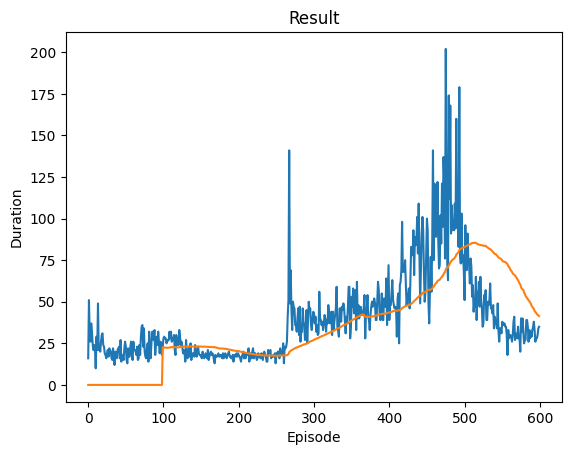

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [39]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 600

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

## ***Observe the effects of changing the exploration vs exploitation. (Show results in plots or print statements):***

Here, We try with the same values that were given in the precode:

Complete


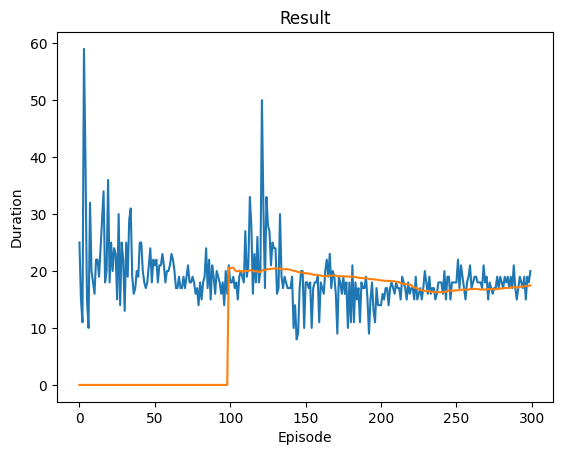

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [43]:
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here, We try a more conservative approach to exploration, changing the EPS_START to 0.5 and also We try a slower decay, allowing more exploration time:

Complete


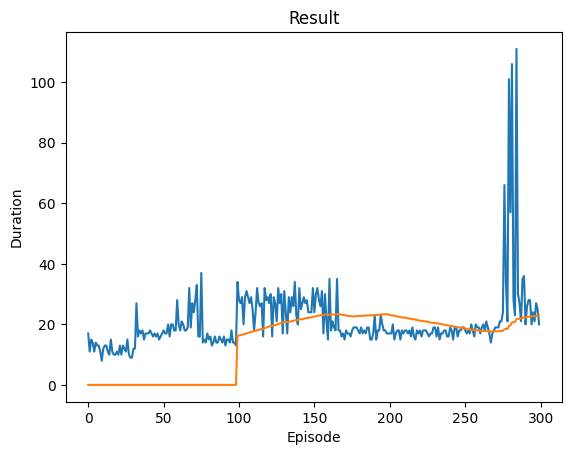

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [40]:
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 200
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here We try a fast Decay that allow us to quickly move from exploring to exploiting the learned values. (EPS_START = 0.9).
Faster Decay, less time spent exploring (EPS_DECAY):

Complete


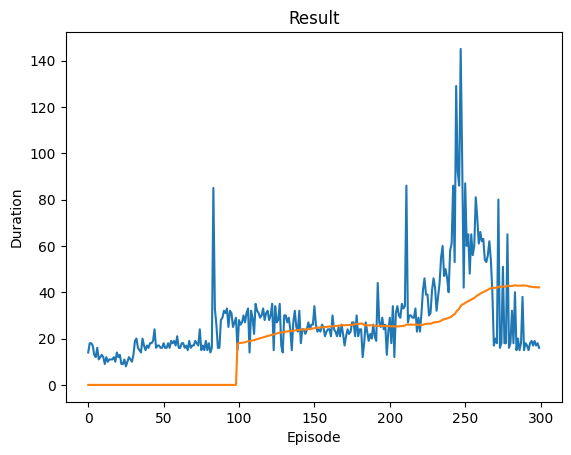

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [69]:
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()


Slow Decay of Exploration: Longer time exploring before settling into exploitation.
Slower decay, more time spent exploring(EPS_DECAY):


Complete


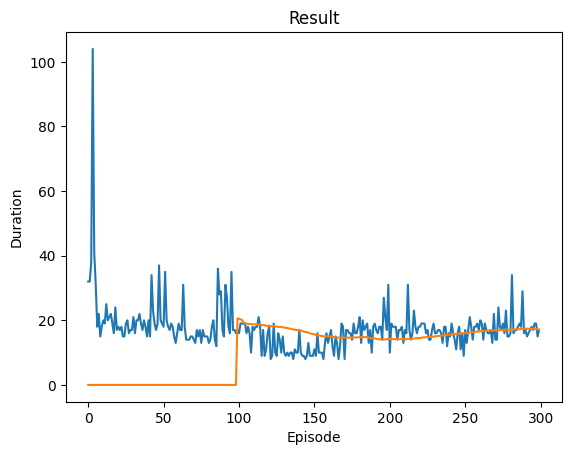

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [70]:
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 300
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

episode_durations = []

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

## ***Vary the number of layers in the model and plot episode vs duration plots. Maybe good to keep an eye on how long!:***

In [45]:
import time

Episode 299 completed in 0.5920958518981934 seconds.
Complete
Total training time: 181.93228602409363 seconds


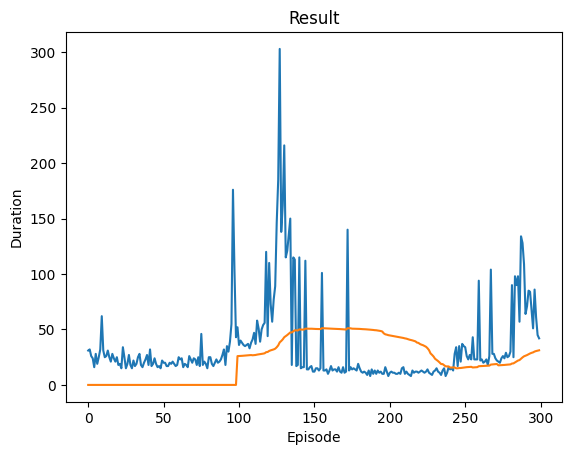

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [46]:
class DQN_4Layer(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_4Layer, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

### ~~~~~~ TRAINING ~~~~~~ ###
total_start_time = time.time()  # Starting the timer for total training time
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN_4Layer(n_observations, n_actions).to(device)
target_net = DQN_4Layer(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


### ~~~~~~ TRAINING LOOP ~~~~~~ ###
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### ~~~~~~ PLOTTING ~~~~~~ ###

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    episode_start_time = time.time()  # Start the timer for the current episode
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            episode_end_time = time.time()  # Ending the timer for the current episode
            print(f"Episode {i_episode} completed in {episode_end_time - episode_start_time} seconds.")
            break

print('Complete')
total_end_time = time.time()  # End the timer for total training time
print(f"Total training time: {total_end_time - total_start_time} seconds")
plot_durations(show_result=True)
plt.ioff()
plt.show()

Episode 299 completed in 1.6951797008514404 seconds.
Complete
Total training time: 341.521475315094 seconds


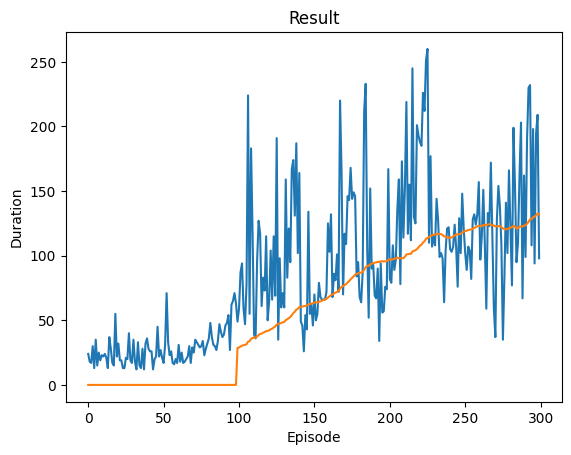

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [48]:
class DQN_5Layer(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN_5Layer, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 128)
        self.layer5 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        return self.layer5(x)

### ~~~~~~ TRAINING ~~~~~~ ###
total_start_time = time.time()  # Starting the timer for total training time
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN_5Layer(n_observations, n_actions).to(device)
target_net = DQN_5Layer(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


### ~~~~~~ TRAINING LOOP ~~~~~~ ###
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### ~~~~~~ PLOTTING ~~~~~~ ###

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    episode_start_time = time.time()  # Starting the timer for the current episode
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            episode_end_time = time.time()  # Ending the timer for the current episode
            print(f"Episode {i_episode} completed in {episode_end_time - episode_start_time} seconds.")
            break

print('Complete')
total_end_time = time.time()  # Ending the timer for total training time
print(f"Total training time: {total_end_time - total_start_time} seconds")
plot_durations(show_result=True)
plt.ioff()
plt.show()


## ***Implement without the replay buffer and observe performance:***

Episode 299 completed in 0.3108174800872803 seconds.
Complete
Total training time: 126.4399836063385 seconds


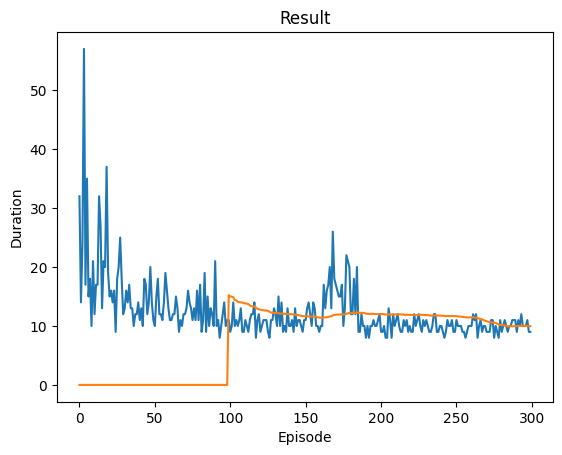

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [49]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### ~~~~~~ TRAINING ~~~~~~ ###
total_start_time = time.time()  # Starting the timer for total training time
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
# memory = ReplayMemory(10000)   -> We remove it in order to not use the replay buffer

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


### ~~~~~~ TRAINING LOOP ~~~~~~ ###

# def optimize_model():
#     if len(memory) < BATCH_SIZE:
#         return
#     transitions = memory.sample(BATCH_SIZE)
#     batch = Transition(*zip(*transitions))
#     non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
#                                           batch.next_state)), device=device, dtype=torch.bool)
#     non_final_next_states = torch.cat([s for s in batch.next_state
#                                                 if s is not None])
#     state_batch = torch.cat(batch.state)
#     action_batch = torch.cat(batch.action)
#     reward_batch = torch.cat(batch.reward)

#     state_action_values = policy_net(state_batch).gather(1, action_batch)

#     next_state_values = torch.zeros(BATCH_SIZE, device=device)
#     with torch.no_grad():
#         next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
#     # Compute the expected Q values
#     expected_state_action_values = (next_state_values * GAMMA) + reward_batch

#     # Compute Huber loss
#     criterion = nn.SmoothL1Loss()
#     loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

#     # Optimize the model
#     optimizer.zero_grad()
#     loss.backward()
#     # In-place gradient clipping
#     torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
#     optimizer.step()

# For implementing it without the replay buffer we will need the following function
# This function teach the agent to predict the value of its action better by continuosly
# learning from the new things it experiences
def optimize_model_single_experience(state, action, next_state, reward):
    # Computing Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken

    # print(f"state shape: {state.shape}")
    # print(f"action shape: {action.shape}")
    # print(f"Q_current shape: {policy_net(state).shape}")

    Q_current = policy_net(state).gather(1, action)
    # the network (policy_net) predicts the Q-values for all possible actions
    # The .gather method is then used to select the Q-values for the action that was actually taken

    # Compute the expected Q values
    Q_next = torch.zeros_like(Q_current) # If it's the end of the episode, the Q-value is assumed to be zero, since there are no future rewards expected
    if next_state is not None: #  If the next state (next_state) is not the end of the episode (i.e., not None)
        Q_next = target_net(next_state).max(1)[0].detach()
        # The target network (target_net) predicts the Q-values for the next state
        # The .max(1)[0] operation selects the maximum Q-value across all possible next actions
    expected_Q = (Q_next * GAMMA) + reward

    # Compute loss
    loss = F.smooth_l1_loss(Q_current, expected_Q.unsqueeze(1))
    # The loss function (F.smooth_l1_loss) computes how much the prediction deviates from the target

    # Optimize the model
    optimizer.zero_grad() # .zero_grad() is called to clear any existing gradients
    loss.backward() # The loss is backpropagated through the network by calling .backward() on it
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1) # he clamp_ operation is used to prevent the gradients from getting too large, which can help stabilize training
    optimizer.step() # After backpropagation, .step() is called on the optimizer to actually perform the weight update


### ~~~~~~ PLOTTING ~~~~~~ ###

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    episode_start_time = time.time()  # Start the timer for the current episode
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Perform one step of the optimization (on the policy network) using the single experience
        optimize_model_single_experience(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            episode_end_time = time.time()  # Ending the timer for the current episode
            print(f"Episode {i_episode} completed in {episode_end_time - episode_start_time} seconds.")
            break

print('Complete')
total_end_time = time.time()  # End the timer for total training time
print(f"Total training time: {total_end_time - total_start_time} seconds")
plot_durations(show_result=True)
plt.ioff()
plt.show()

# **TASK 3:**
## ***Implement Q-learning and SARSA for the CartPole-V1 Environment.***

# Traditional Q-learning Implementation for "CartPole-v1"

The code represents an implementation of the traditional tabular Q-learning algorithm applied to the "CartPole-v1" environment from OpenAI Gym. Below is a concise report of the approach and mathematical formulation:

## Problem Statement

The agent's goal is to balance a pole on a cart by applying forces to the cart's left or right side, receiving a set of continuous variables that represent the cart's position and velocity, along with the pole's angle and rotation rate.

## Discretization

The continuous state space is discretized into bins. Each continuous state variable is divided into a fixed number of bins, effectively transforming it into a categorical variable:

$$
s'_i = \left\lfloor \frac{s_i + |s_{\text{min}, i}|}{s_{\text{max}, i} - s_{\text{min}, i}} \times (\text{bins}_i - 1) \right\rceil
$$

where $s_i$ is the continuous state value, $s'_i$ is the discretized state index, $s_{\text{min}, i}$ and $s_{\text{max}, i}$ are the lower and upper bounds for state variable $i$, and $\text{bins}_i$ is the number of bins for state variable $i$.

## Q-learning Algorithm

The Q-table, representing the action-value function, is updated iteratively using the Q-learning update rule:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Here, $Q(s, a)$ is the current Q-value estimate, $r$ is the received reward, $s'$ is the new state, $a'$ are possible actions in the new state, $\alpha$ is the learning rate, and $\gamma$ is the discount factor.

## Exploration Strategy

An epsilon-greedy strategy is employed where:

- With probability $\epsilon$, a random action is chosen (exploration).
- With probability $1 - \epsilon$, the action with the highest estimated Q-value is chosen (exploitation).
- $\epsilon$ decays after each episode to favor exploitation over time.

## Hyperparameters

- $\alpha = 0.1$: Learning rate.
- $\gamma = 0.99$: Discount factor for future rewards.
- $\epsilon = 1.0$: Initial exploration rate.
- $\text{min\_epsilon} = 0.01$: Ensures some level of exploration.
- $\text{epsilon\_decay} = 0.995$: Rate of decay for $\epsilon$ per episode.

## Learning Process

The algorithm is executed for 100,000 episodes. In each episode, the pole's balance is maintained through a series of steps until termination. The Q-table is updated at every step following the Q-learning rule.

## Results

The episode durations, indicating how long the pole was balanced, are recorded and plotted. An increasing trend over episodes is expected, signaling improved policy learning.

## Visualization

The learning progression is visualized through a plot of episode durations over time, where the y-axis represents the number of timesteps the pole remained balanced, and the x-axis represents the episode number.



Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000
Episode: 10000


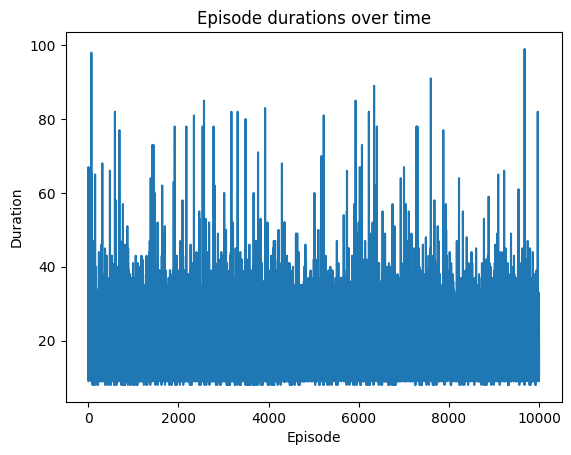

In [7]:
import gymnasium as gym
import math
import matplotlib.pyplot as plt
import numpy as np

env = gym.make("CartPole-v1")


# Discretize the continuous state space into bins
def discretize_state(state, bins=[18, 14, 18, 14]):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    new_state = [int(round((bins[i] - 1) * ratios[i])) for i in range(len(state))]
    new_state = [min(bins[i] - 1, max(0, new_state[i])) for i in range(len(state))]
    return tuple(new_state)

# Initialize Q-table
q_table = np.zeros([18, 14, 18, 14, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
min_epsilon = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Exploration decay rate

episode_durations = []  # List to store each episode duration

for i_episode in range(1, 10001):  # Running 1000 episodes for illustration
    initial_state, _ = env.reset()  # Correctly reset the environment to get the initial state
    state = discretize_state(initial_state)  # Discretize the state

    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        #print(env.step(action))
        next_state, reward, done, extra_boolean, info = env.step(action)
        next_state = discretize_state(next_state)

        old_value = q_table[state + (action,)]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state + (action,)] = new_value

        state = next_state
        epochs += 1

        if done and epsilon > min_epsilon:
            epsilon *= epsilon_decay

    episode_durations.append(epochs)  # Append the duration of the episode

    if i_episode % 1000 == 0:
        print(f"Episode: {i_episode}")

#print("Training finished.\n")
# Plotting the episode durations
plt.plot(episode_durations)
plt.title('Episode durations over time')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()


Episode: 10000
Episode: 20000
Episode: 30000
Episode: 40000
Episode: 50000
Episode: 60000
Episode: 70000
Episode: 80000
Episode: 90000
Episode: 100000


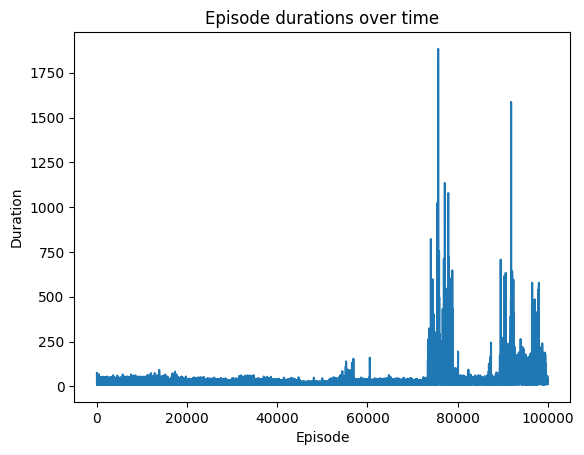

In [4]:
import gymnasium as gym
import math
import matplotlib.pyplot as plt
import numpy as np

env = gym.make("CartPole-v1")


# Discretize the continuous state space into bins
def discretize_state(state, bins=[18, 14, 18, 14]):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    new_state = [int(round((bins[i] - 1) * ratios[i])) for i in range(len(state))]
    new_state = [min(bins[i] - 1, max(0, new_state[i])) for i in range(len(state))]
    return tuple(new_state)

# Initialize Q-table
q_table = np.zeros([18, 14, 18, 14, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
min_epsilon = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Exploration decay rate

episode_durations = []  # List to store each episode duration

for i_episode in range(1, 100001):  # Running 1000 episodes for illustration
    initial_state, _ = env.reset()  # Correctly reset the environment to get the initial state
    state = discretize_state(initial_state)  # Discretize the state

    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values

        #print(env.step(action))
        next_state, reward, done, extra_boolean, info = env.step(action)
        next_state = discretize_state(next_state)

        old_value = q_table[state + (action,)]
        next_max = np.max(q_table[next_state])

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state + (action,)] = new_value

        state = next_state
        epochs += 1

        if done and epsilon > min_epsilon:
            epsilon *= epsilon_decay

    episode_durations.append(epochs)  # Append the duration of the episode

    if i_episode % 10000 == 0:
        print(f"Episode: {i_episode}")

#print("Training finished.\n")
# Plotting the episode durations
plt.plot(episode_durations)
plt.title('Episode durations over time')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()


#### SARSA:


# SARSA Implementation for "CartPole-v1"

The following is an implementation of the SARSA (State-Action-Reward-State-Action) on-policy algorithm applied to the "CartPole-v1" environment from OpenAI Gym.

## Problem Statement

The "CartPole-v1" task is a classic reinforcement learning problem where the goal is to balance a pole on a moving cart. The state consists of continuous variables such as the cart's position and velocity, and the pole's angle and rotation rate.

## Discretization

To apply SARSA to this environment, the continuous state space is discretized into bins. The discretization process involves dividing each state dimension into a predefined number of bins, transforming continuous state variables into discrete ones:

$$
s'_i = \left\lfloor \frac{s_i + |s_{\text{min}, i}|}{s_{\text{max}, i} - s_{\text{min}, i}} \times (\text{bins}_i - 1) \right\rceil
$$

Here, $s_i$ is a continuous state variable, $s_{\text{min}, i}$ and $s_{\text{max}, i}$ are its observed minimum and maximum values, $\text{bins}_i$ is the number of bins for the $i^{th}$ state variable, and $s'_i$ is the resulting discretized state.

## SARSA Algorithm

The SARSA algorithm updates an action-value Q-table using the following update rule:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma Q(s', a') - Q(s, a) \right]
$$

where $s$ is the current state, $a$ is the current action, $r$ is the reward received, $s'$ is the new state, $a'$ is the action chosen in the new state according to the current policy, $\alpha$ is the learning rate, and $\gamma$ is the discount factor.

## Hyperparameters

- $\alpha = 0.1$: The learning rate determines the step size in updating Q-values.
- $\gamma = 0.99$: The discount factor weighs the importance of future rewards.
- $\epsilon = 1.0$: The initial rate of exploration, with a gradual decay to encourage exploitation over time.
- $\text{min\_epsilon} = 0.01$: The minimum exploration rate to ensure the agent continues to explore throughout training.
- $\text{epsilon\_decay} = 0.995$: The decay rate of exploration per episode.

## Training Process

The training involves running a predefined number of episodes. In each episode, the agent selects actions using an $\epsilon$-greedy policy, updates the Q-table following the SARSA update rule, and tracks the episode duration for analysis.

## Results

The episode durations are stored and plotted to evaluate the learning progression. An increasing trend in the plot indicates the agent's improvement at maintaining the pole's balance for more extended periods.

## Visualization

A plot of episode durations against the episode number showcases the learning progress over time. It's expected that as episodes increase, the durations will trend upwards, reflecting the agent's improved policy.



Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000
Episode: 10000


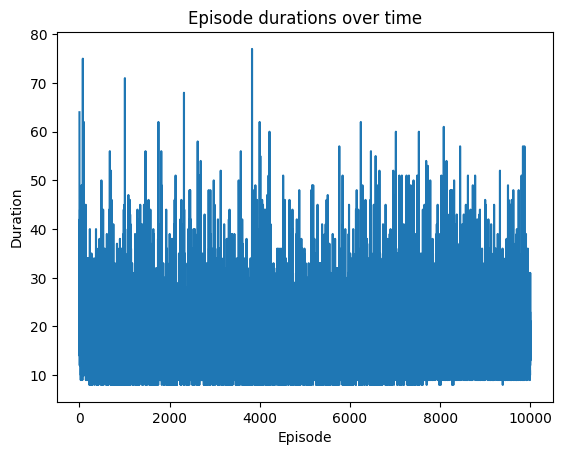

In [5]:
import gymnasium as gym
import math
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")

def discretize_state(state, bins=[18, 14, 18, 14]):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    new_state = [int(round((bins[i] - 1) * ratios[i])) for i in range(len(state))]
    new_state = [min(bins[i] - 1, max(0, new_state[i])) for i in range(len(state))]
    return tuple(new_state)

# Initialize Q-table
q_table = np.zeros([18, 14, 18, 14, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
min_epsilon = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Exploration decay rate

episode_durations = []  # List to store each episode duration

for i_episode in range(1, 10001):  # Running 10000 episodes for illustration
    initial_state, _ = env.reset()  # Correctly reset the environment to get the initial state
    state = discretize_state(initial_state)  # Discretize the state

    # Choose action A from state S using policy derived from Q (e.g., ε-greedy)
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()  # Explore
    else:
        action = np.argmax(q_table[state])  # Exploit

    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        next_state, reward, done, extra_boolean, info = env.step(action)
        next_state = discretize_state(next_state)

        # Choose action A' from state S' using policy derived from Q (e.g., ε-greedy)
        if np.random.uniform(0, 1) < epsilon:
            next_action = env.action_space.sample()  # Explore
        else:
            next_action = np.argmax(q_table[next_state])  # Exploit

        old_value = q_table[state + (action,)]
        next_value = q_table[next_state + (next_action,)]  # SARSA: Using the next action for update

        # SARSA update rule
        new_value = old_value + alpha * (reward + gamma * next_value - old_value)
        q_table[state + (action,)] = new_value

        # S <- S'; A <- A' for the next iteration
        state, action = next_state, next_action

        epochs += 1

        if done and epsilon > min_epsilon:
            epsilon *= epsilon_decay

    episode_durations.append(epochs)  # Append the duration of the episode

    if i_episode % 1000 == 0:
        print(f"Episode: {i_episode}")

#print("Training finished.\n")
# Plotting the episode durations
plt.plot(episode_durations)
plt.title('Episode durations over time')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()


Episode: 10000
Episode: 20000
Episode: 30000
Episode: 40000
Episode: 50000
Episode: 60000
Episode: 70000
Episode: 80000
Episode: 90000
Episode: 100000


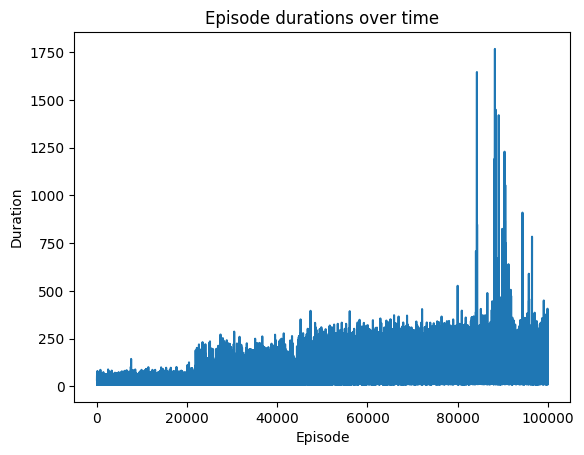

In [5]:
import gymnasium as gym
import math
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("CartPole-v1")

def discretize_state(state, bins=[18, 14, 18, 14]):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    new_state = [int(round((bins[i] - 1) * ratios[i])) for i in range(len(state))]
    new_state = [min(bins[i] - 1, max(0, new_state[i])) for i in range(len(state))]
    return tuple(new_state)

# Initialize Q-table
q_table = np.zeros([18, 14, 18, 14, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration rate
min_epsilon = 0.01  # Minimum exploration rate
epsilon_decay = 0.995  # Exploration decay rate

episode_durations = []  # List to store each episode duration

for i_episode in range(1, 100001):  # Running 10000 episodes for illustration
    initial_state, _ = env.reset()  # Correctly reset the environment to get the initial state
    state = discretize_state(initial_state)  # Discretize the state

    # Choose action A from state S using policy derived from Q (e.g., ε-greedy)
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()  # Explore
    else:
        action = np.argmax(q_table[state])  # Exploit

    epochs, penalties, reward = 0, 0, 0
    done = False

    while not done:
        next_state, reward, done, extra_boolean, info = env.step(action)
        next_state = discretize_state(next_state)

        # Choose action A' from state S' using policy derived from Q (e.g., ε-greedy)
        if np.random.uniform(0, 1) < epsilon:
            next_action = env.action_space.sample()  # Explore
        else:
            next_action = np.argmax(q_table[next_state])  # Exploit

        old_value = q_table[state + (action,)]
        next_value = q_table[next_state + (next_action,)]  # SARSA: Using the next action for update

        # SARSA update rule
        new_value = old_value + alpha * (reward + gamma * next_value - old_value)
        q_table[state + (action,)] = new_value

        # S <- S'; A <- A' for the next iteration
        state, action = next_state, next_action

        epochs += 1

        if done and epsilon > min_epsilon:
            epsilon *= epsilon_decay

    episode_durations.append(epochs)  # Append the duration of the episode

    if i_episode % 10000 == 0:
        print(f"Episode: {i_episode}")

#print("Training finished.\n")
# Plotting the episode durations
plt.plot(episode_durations)
plt.title('Episode durations over time')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.show()


# **BONUS TASK:**
## ***Implement any other RL algorithm on either of the environments***

# Categorical DQN (C51) Implementation for "CartPole-v1"

The code outlines the Categorical DQN (C51) algorithm's implementation for the "CartPole-v1" environment from OpenAI Gym.

## Problem Statement

The "CartPole-v1" challenge involves controlling a cart with a pole balanced on top. Success is measured by the cart's ability to keep the pole upright by moving left or right.

## C51 DQN Algorithm

C51 extends the traditional DQN by estimating a value distribution instead of only expected value for each action. The key components of C51 are as follows:

### Network Architecture

The neural network comprises an input layer matching the observation space dimensions, several hidden layers (here, two with 128 units each), and an output layer that produces a value distribution for each action over a fixed number of support (`N`) locations.

### Value Distribution

The algorithm defines a range `[Vmin, Vmax]` for the value distribution and discretizes it into `N` bins. The network output is then a set of probabilities over these bins for each action.

### Update Mechanism

The loss function used is the cross-entropy between the projected value distribution of the optimal action in the next state and the distribution output by the network for the chosen action in the current state.

The update rule can be expressed as:

$$
L_i(\theta) = \mathbb{E} \left[ D_{KL} \left( \Phi_{TZ} \left( R_{t+1} + \gamma Z_{t+1} \mid Z_t, A_t \right) || Z_\theta(S_t, A_t) \right) \right]
$$

Here, $ (D_{KL}$) denotes the Kullback-Leibler divergence, $( \Phi_{TZ} $) is the projection operator mapping the Bellman update distribution back onto the original support, $( R_{t+1} $) is the reward at the next timestep, $( \gamma $) is the discount factor, \( Z \) represents the value distribution, and $( \theta $) are the parameters of the neural network.

## Training Loop

The training process involves iterating over episodes, performing actions in the environment, storing transitions in replay memory, and regularly updating the model parameters based on sampled minibatches.

## Replay Memory

A replay memory buffer stores past transition tuples of the form `(state, action, next_state, reward)`. The buffer enables experience replay, mitigating correlations in the update sequence and smoothing over changes in the data distribution.

## Hyperparameters

- `N = 51`: Number of atom bins for value distribution.
- `BATCH_SIZE = 128`: Minibatch size for updates.
- `GAMMA = 0.99`: Discount factor for future rewards.
- `EPS_START = 0.9` to `EPS_END = 0.05`: Epsilon range for epsilon-greedy strategy.
- `EPS_DECAY = 1000`: Decay rate for exploration probability.
- `TAU = 0.005`: Soft update rate for the target network.
- `LR = 1e-4`: Learning rate.

## Performance Visualization

Episode durations, reflecting how long the agent can keep the pole upright, are recorded after each episode. This metric is plotted to visualize learning progress and policy performance over time.



In [ ]:
%%bash
pip install gymnasium[classic_control]
pip install torch

Complete


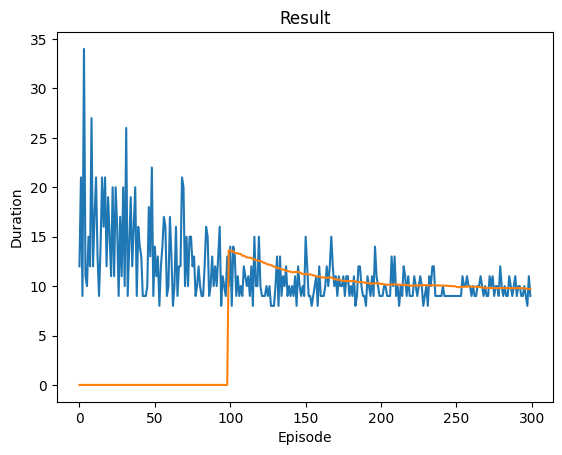

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# Setting up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### ~~~~~~ REPLAY MEMORY ~~~~~~ ###
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### ~~~~~~ C51 DQN ALGORITHM ~~~~~~ ###
class C51DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(C51DQN, self).__init__()

        self.N = N
        self.Vmin = -10
        self.Vmax = 10
        self.delta_z = (self.Vmax - self.Vmin) / (self.N - 1)
        self.z = torch.linspace(self.Vmin, self.Vmax, self.N)

        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions * N)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x).view(-1, n_actions, self.N)

    def get_q_values(self, state):
        # Get the expected Q values by summing over the distributions
        return torch.sum(F.softmax(self(state), dim=2) * self.z, dim=2)

### ~~~~~~ Hyperparameters and utilities Training ~~~~~~ ###

# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

N = 51 # Number of atoms
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = C51DQN(n_observations, n_actions).to(device)
target_net = C51DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            q_values = policy_net(state)
            action_distribution = F.softmax(q_values, dim=-1)
            action = torch.multinomial(action_distribution.view(-1), 1).item()
            return torch.tensor(action, device=device, dtype=torch.long).clamp(0, env.action_space.n - 1).view(1, 1)
            # return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### ~~~~~~ TRAINING LOOP ~~~~~~ ###
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # This converts batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Computing a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a)
    # Getting distributions for actions taken in state_batch

    # Compute the current state's distribution: shape [batch_size, num_actions, N]
    state_action_values = policy_net(state_batch)

    # Select the distributions for the chosen actions: shape [batch_size, N]
    action_indices = action_batch.unsqueeze(-1).expand(-1, -1, policy_net.N)
    chosen_state_action_values = state_action_values.gather(1, action_indices).squeeze(1)

    # Compute V(s_{t+1}) for all next states using target network
    next_state_values = torch.zeros(BATCH_SIZE, policy_net.N, device=device)

    # Compute a distribution for non-final next states
    if non_final_mask.sum() > 0:
        non_final_next_distributions = F.softmax(target_net(non_final_next_states), dim=2)
        best_next_actions = non_final_next_distributions * policy_net.z
        best_next_actions = best_next_actions.sum(dim=2).max(1)[1].unsqueeze(-1).unsqueeze(-1).expand(non_final_mask.sum(), 1, policy_net.N)
        best_next_distributions = non_final_next_distributions.gather(1, best_next_actions).squeeze(1)

        updated_next_state_values = torch.zeros_like(next_state_values)
        non_final_indices = non_final_mask.nonzero(as_tuple=True)[0]

        # Bellman update: project the future reward distribution
        for idx, non_final_next_state in enumerate(non_final_next_states):
            tz_j = reward_batch[idx] + GAMMA * policy_net.z
            tz_j = tz_j.clamp(min=policy_net.Vmin, max=policy_net.Vmax)
            b_j = (tz_j - policy_net.Vmin) / policy_net.delta_z
            l = b_j.floor().long()
            u = b_j.ceil().long()

            l = l.clamp(min=0, max=policy_net.N - 1)
            u = u.clamp(min=0, max=policy_net.N - 1)

            # print("Shape of next_state_values:", next_state_values.shape)
            # print("Shape of l:", l.shape)
            # print("Shape of u:", u.shape)
            # print("Shape of best_next_distributions:", best_next_distributions.shape)
            # print("Shape of (u.float() - b_j):", (u.float() - b_j).shape)
            # print("Shape of best_next_distributions * (u.float() - b_j):",
            #     (best_next_distributions * (u.float() - b_j)).shape)

            for atom_index in range(policy_net.N):
                l_index = l[atom_index]
                u_index = u[atom_index]
                next_state_values[idx, l_index] += best_next_distributions[idx, atom_index] * (u[atom_index].float() - b_j[atom_index])
                next_state_values[idx, u_index] += best_next_distributions[idx, atom_index] * (b_j[atom_index] - l[atom_index].float())

        #next_state_values = updated_next_state_values

    # Computing the cross entropy loss between projected distributions and model distributions
    log_p = torch.log(chosen_state_action_values + 1e-8)
    loss = -torch.sum(next_state_values * log_p, dim=1).mean()

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    # Update the target network
    # Clipping gradients is common for stability
    with torch.no_grad():
        for target_param, local_param in zip(target_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)

  ### ~~~~~~ RUNNING IT ~~~~~~ ###
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 300

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

### That's all, Thank you for reading!
### *Antonio.*
